In [174]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
from tqdm import tnrange, tqdm_notebook
from time import sleep, time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

warnings.filterwarnings('ignore')
HOLDOUT = 10
R = 0.01
os.chdir("C:\\Users\\Emanuel\\Downloads\\PIC\\PIC_AM")
os.getcwd()

'C:\\Users\\Emanuel\\Downloads\\PIC\\PIC_AM'

In [175]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    #print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    #print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [176]:
def CarregarAtt():
    folders = glob.glob("databases/att_faces/*")
    images_att = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_att.extend(images_flatten)
        Y.extend([f] * 10)
    return np.array(images_att), Y
    #return folders

In [177]:
def CarregarSheffield():
    folders = glob.glob("databases/sheffield/cropped/*")
    images_sheffield = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/face/*")
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        images_flatten = [image.flatten() for image in images_resized]
        images_sheffield.extend(images_flatten)
        Y.extend([f] * len(files))
    return np.array(images_sheffield), Y

In [178]:
print(CarregarYaleFaces()[0].shape)
print(CarregarAtt()[0].shape)
print(CarregarSheffield()[0].shape)

(165, 644)
(400, 644)
(575, 644)


In [179]:
def PCA(X, W, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        b = X[i] - mean
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    X_ = vec.T.dot((X - mean).T)
    X__ = vec.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]

In [180]:
def FPCA(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    mean = np.power(mean, r)
    X = np.power(X, r)
    W = np.power(W, r)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        #b = X[i] - mean
        b = a.T
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    #val = np.abs(val)
    X_ = vec.T.dot((X - mean).T)
    X__ = vec.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]


In [181]:
def Eigenfaces(X, W, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = X[:,j] - X[:,j].mean()
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5) #eq 7
    vec_c = vec_c * (X - mean).T.dot(vec) #eq 7
    X_ = vec_c.T.dot((X - mean).T)
    X__ = vec_c.T.dot((W - mean).T)
    return X_.T[:,:k], X__.T[:,:k]

In [182]:
def F_Eigenfaces(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, r) - np.power(mean,r)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X,r) - np.power(mean,r)).T)
    X__ = vec_c.T.dot((np.power(W,r) - np.power(mean,r)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [183]:
def AvaliarClassificadores(X, Y):
    scores_1nn = []
    
    for i in range(HOLDOUT):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
        clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
        scores_1nn.append(clf_1nn.score(X_test, y_test))

    scores_1nn = np.array(scores_1nn).mean() * 100
    return scores_1nn

In [184]:
def AvaliarClassificadores2(X_train, X_test, y_train, y_test):
    
    clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    return clf_1nn.score(X_test, y_test) * 100

In [205]:
def Experimento(X, Y):
    acc = []
    std = []
    
    n_componentes = 1
    
    #for i in tqdm(range(1, 16)):
    for i in tnrange(15, desc='Progresso '):
    
        #print('# Progresso :'+str(n_componentes)+'/70')
        
        #s_pca = []
        s_fpca = []
        s_eige = []
        s_feig = []

        #for j in range(HOLDOUT):
        for j in tqdm_notebook(range(HOLDOUT), desc='Nº c:{0}'.format(n_componentes)):
        
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state= round(time()) + 15 * j)
            #print(X_train)

            #gerar os conjuntos de treino e teste transformados
            #X_pca_train, X_pca_test  = PCA(X_train, X_test, n_componentes)
            X_fpca_train, X_fpca_test = FPCA(X_train, X_test, n_componentes, R)
            X_eige_train, X_eige_test = Eigenfaces(X_train, X_test, n_componentes)
            X_feig_train, X_feig_test = F_Eigenfaces(X_train, X_test, n_componentes, R)

            #acuracias
            #s_pca.append(AvaliarClassificadores2(X_pca_train, X_pca_test, y_train, y_test))X_eige_test
            s_fpca.append(AvaliarClassificadores2(X_fpca_train, X_fpca_test, y_train, y_test))
            s_eige.append(AvaliarClassificadores2(X_eige_train, X_eige_test, y_train, y_test))
            s_feig.append(AvaliarClassificadores2(X_feig_train, X_feig_test, y_train, y_test))

        #print(s_fpca)
        acc.append([#np.array(s_pca).mean(),
                    np.array(s_fpca).mean(),
                    np.array(s_eige).mean(),
                    np.array(s_feig).mean()])
        
        std.append([#np.std(s_pca),
                    np.std(s_fpca) / 100,
                    np.std(s_eige) / 100,
                    np.std(s_feig) / 100])
        
        if(n_componentes == 1):
            n_componentes += 4
        else:
            n_componentes += 5
            
            sleep(0.01)
        
    return np.array(acc), np.array(std)

In [206]:
def ImprimirResultados(acc, dataset_name):
    
    x = np.arange(0, 15)
    x = x * 5
    x[0] += 1
    print(len(x))
    #plt.figure(figsize=(20,15))
    plt.title("Dataset: "+dataset_name+" - Classifier: 1-NN")
    #plt.plot(x, acc_yale[:,0], color='black')
    plt.plot(x, acc[:,0], color='red')
    plt.plot(x, acc[:,1], color='blue')
    plt.plot(x, acc[:,2], color='orange')
    plt.ylabel('Acuracia media')
    plt.xlabel('Numero de componentes')
    #plt.legend(labels=['PCA','FPCA','Eigenfaces','F Eigenfaces'])
    plt.legend(labels=['FPCA','Eigenfaces','F Eigenfaces'])
    plt.grid()
    plt.show()

In [207]:
def ImprimirTabela(acc, std):
    i = 1
    for a, s in zip(acc, std):
        print(str(i)+"\t{0:.3f}".format(a[0])+" +-"+"{0:.3f}".format(s[0])+
              "\t"+"{0:.3f}".format(a[1])+" +-"+"{0:.3f}".format(s[1])+
              "\t"+"{0:.3f}".format(a[2])+" +-"+"{0:.3f}".format(s[2]))
        if(i == 1):
            i += 4
        else:
            i += 5

In [ ]:
#calculando as acuracias (70 x 4)
print("---Yale---")
X, Y = CarregarYaleFaces()
acc_yale, std_yale = Experimento(X, Y)
print("---AT&T---")
X, Y = CarregarAtt()
acc_att, std_att = Experimento(X, Y)
print("---Sheffield---")
X, Y = CarregarSheffield()
acc_sheffield, std_sheffield = Experimento(X, Y)

---Yale---


---AT&T---


---Sheffield---


In [ ]:
ImprimirResultados(acc_yale, "Yale Faces")

In [ ]:
ImprimirResultados(acc_att, "AT&T Faces")

15


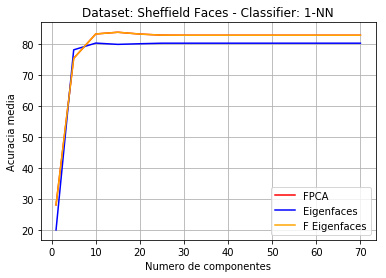

In [121]:
ImprimirResultados(acc_sheffield, "Sheffield Faces")

In [135]:
print("\t+--------------------Yale--------------------+")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_yale, std_yale)

print("\t---------------------AT&T---------------------")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_att, std_att)

print("\t------------------Sheffield-------------------")
print("\t-----FPCA---------Eigenfaces-----F Eigenfaces-")
ImprimirTabela(acc_sheffield, std_sheffield)

	+--------------------Yale--------------------+
	-----FPCA---------Eigenfaces-----F Eigenfaces-
1	25.060 +-0.038	26.386 +-0.034	25.060 +-0.038
5	62.289 +-0.067	62.892 +-0.055	62.289 +-0.067
10	66.747 +-0.050	67.952 +-0.055	66.747 +-0.050
15	68.193 +-0.076	69.880 +-0.049	68.193 +-0.076
20	70.964 +-0.065	70.482 +-0.046	70.964 +-0.065
25	74.699 +-0.065	71.687 +-0.046	74.699 +-0.065
30	76.265 +-0.064	71.928 +-0.039	76.265 +-0.064
35	76.145 +-0.067	71.928 +-0.040	76.145 +-0.067
40	77.952 +-0.064	72.410 +-0.038	77.831 +-0.063
45	77.952 +-0.072	72.169 +-0.036	77.952 +-0.072
50	78.554 +-0.069	72.289 +-0.042	78.675 +-0.068
55	78.675 +-0.066	72.771 +-0.044	78.675 +-0.066
60	78.554 +-0.065	72.771 +-0.042	78.554 +-0.065
65	78.795 +-0.068	72.771 +-0.037	78.916 +-0.068
70	78.795 +-0.070	72.651 +-0.038	78.795 +-0.068
	---------------------AT&T---------------------
	-----FPCA---------Eigenfaces-----F Eigenfaces-
1	21.050 +-0.056	15.800 +-0.013	21.050 +-0.056
5	58.700 +-0.021	61.800 +-0.016	58.700 +-0.